# Classifiez automatiquement des biens de consommation - partie textuelle - modélisation non supervisée

## 1. Introduction

__Contexte__

Place de marché® est un e-commerce qui met direction en relation les vendeurs et les acheteurs. A ce jour, les vendeurs doivent insérer une photo, une description du produit qu'ils vendent et aussi le trier dans sa catégorie. Cependant, il arrive que ces derniers se trompent dans lorsqu'ils le catégorisent. 

__Problématiques__

C'est pourquoi Place de marché souhaite automatiser la catégorisation des produits à partir de son image et/ou de sa description avec l'aide d'un moteur de classifiation automatique.

__Droits d'utilisation des données Flipkart__

Le dossier Flipkart a été échantillonné à partir des données mises sur Kaggle, avec l'autorisation de Flipkart: comme il est visible dans cette image ci-dessous où nous voyons qu'ils sont sous la licence [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) qui stipule qu'il est possible d'utiliser, de modifier et de partager ces données. Nous pouvons donc continuer le reste de l'étude de faisabilité sans nous soucier d'enfreindre la loi de ce côté-là. 

Cependant cela n'inclut que le dataframe. Malheureusement, j'ai beau cherché, rien n'indique que les images peuvent être utilisées: voire même Flipkart stipule dans sa page "https://affiliate.flipkart.com/terms-of-use" dans la section "Trademark, Copyright and Restriction" que nous ne pouvons pas l'utiliser sans leur autorisation. Cependant, comme ce dataset est utilisé par OpenClassrooms, j'en ai conclu qu'il était possible que je travaille sur ce dernier. 

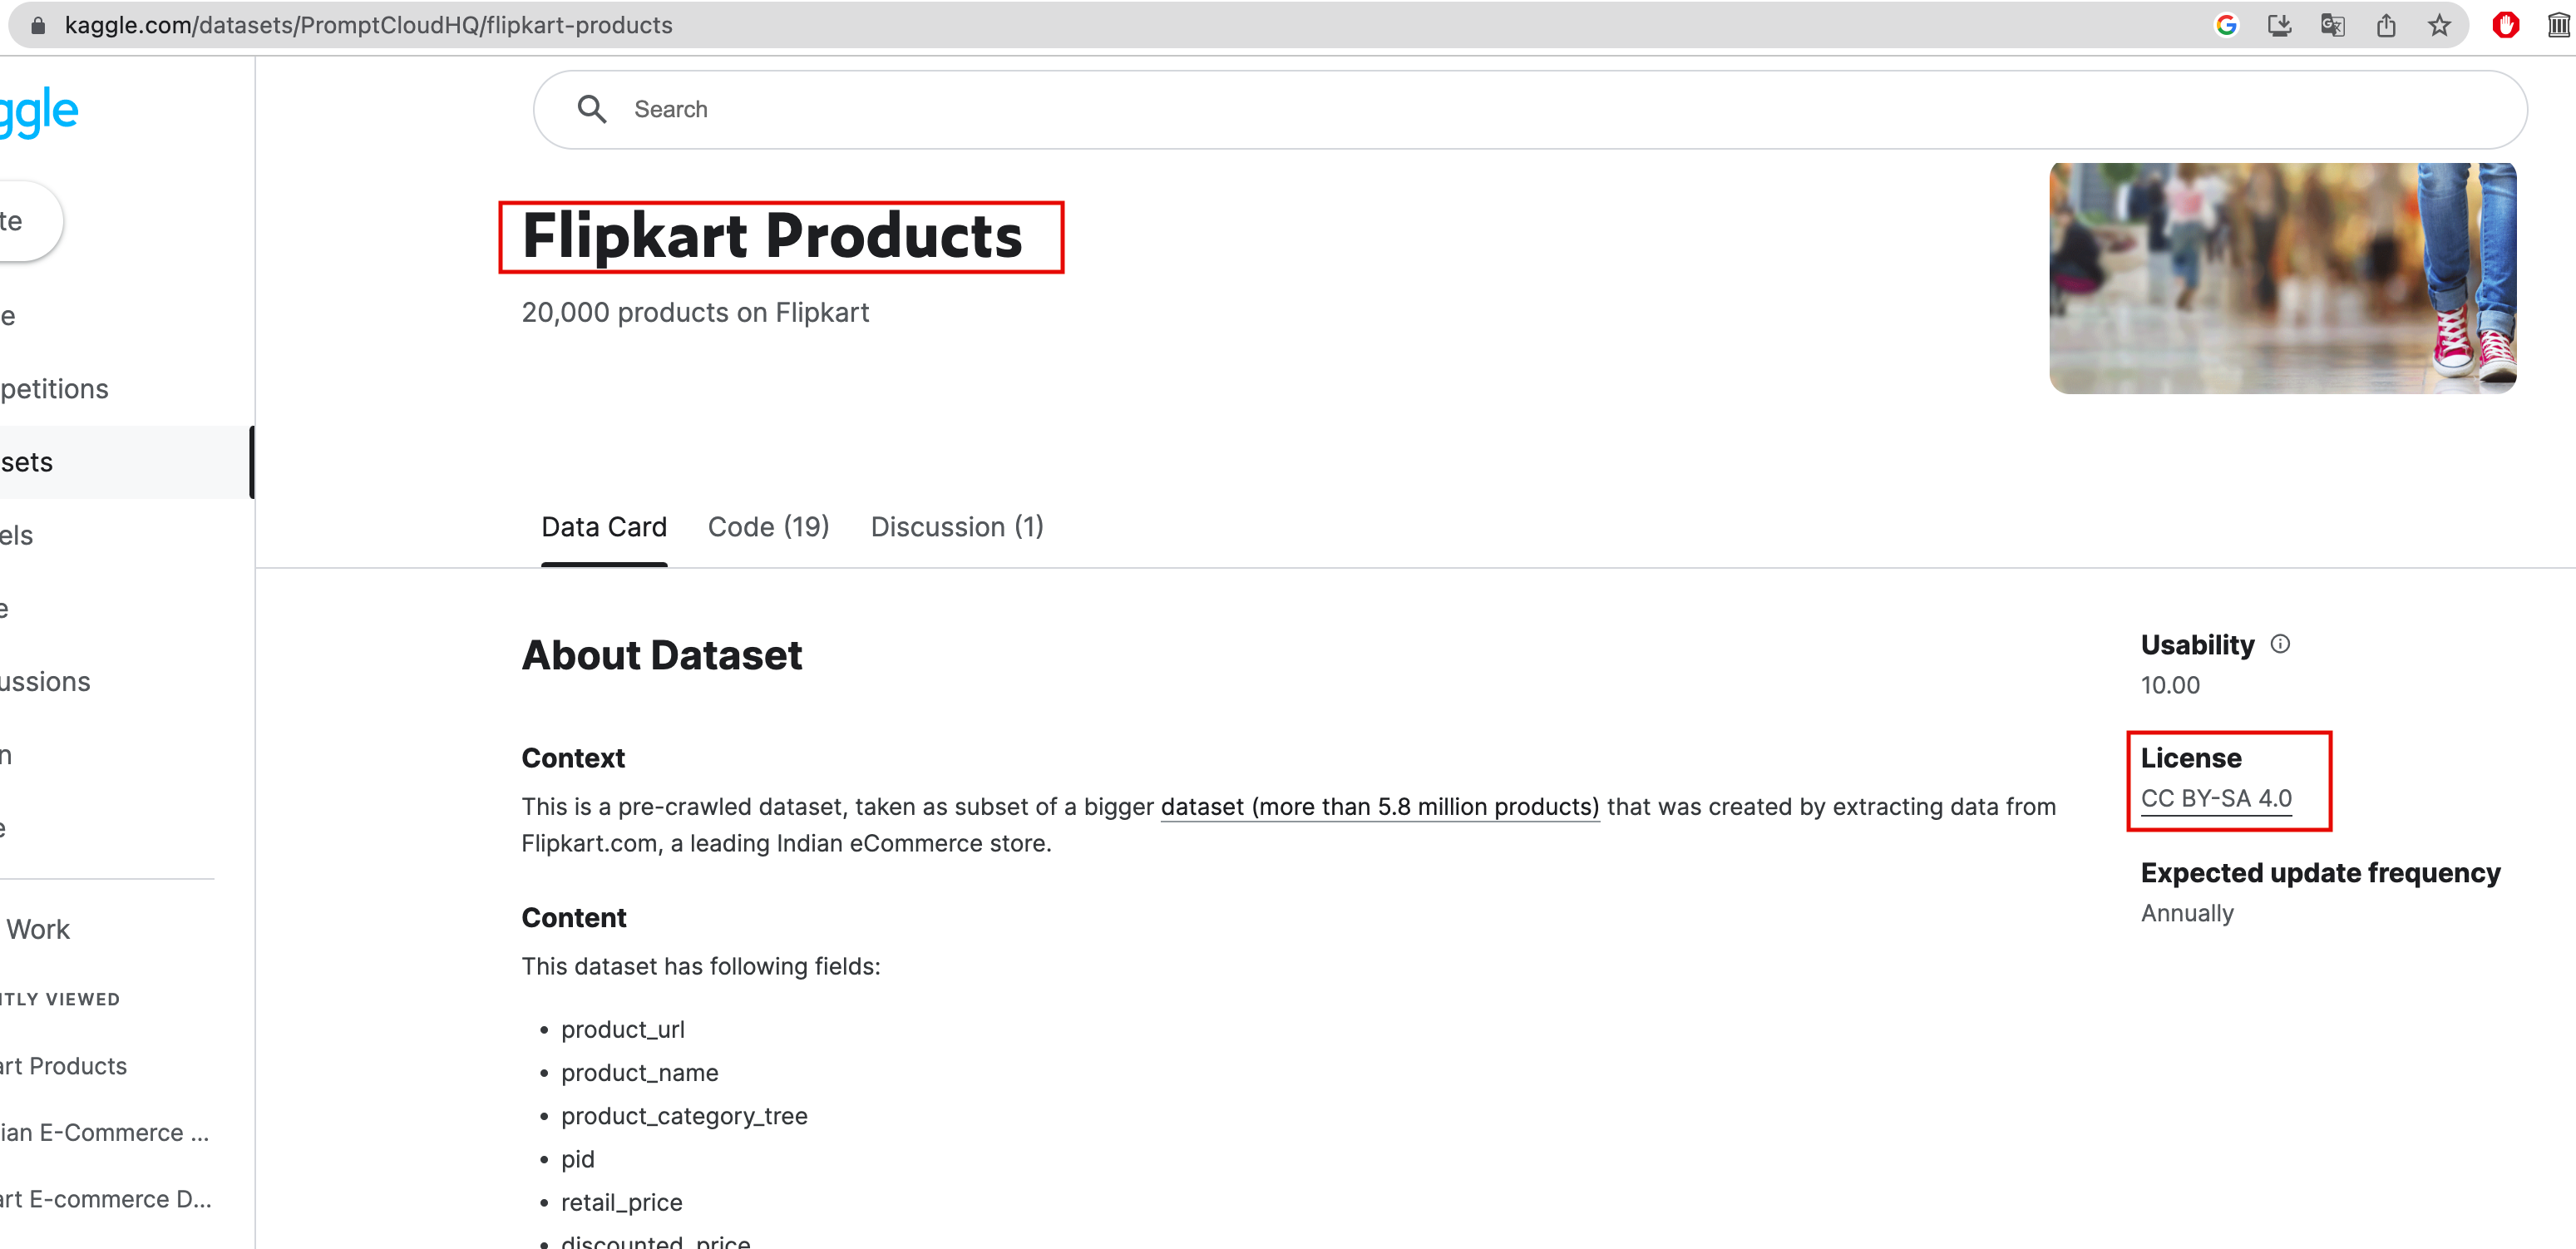

### Les critères à remplir dans ce notebook
   1. __Prétraiter des données images pour obtenir un jeu de données exploitable.__
      - CE1 Vous avez utilisé des librairies spécialisées pour un premier traitement du contraste (ex. : openCV). 
      - CE3 Vous avez élaboré une fonction permettant d'extraire des features ("feature engineering") de type "bag-of-images" via la génération de descripteurs (algorithmes ORB, ou SIFT, ou SURF). 
      - CE4 Vous avez élaboré et exécuté une fonction permettant d'extraire des features ("feature engineering") via un algorithme de Transfer Learning basé sur des réseaux de neurones, comme par exemple CNN. 

   2. __Mettre en œuvre des techniques de réduction de dimension.__
      - CE1 Vous avez justifié la nécessité de la réduction de dimension. 
      - CE2 Vous avez appliqué une méthode de réduction de dimension adaptée à la problématique (ex. : ACP). 
      - CE3 Vous avez justifié le choix des valeurs des paramètres dans la méthode de réduction de dimension retenue (ex. : le nombre de dimensions conservées pour l'ACP).  
 
   3. __Représenter graphiquement des données à grandes dimensions.__
      - CE1 Vous avez mis en œuvre au moins une technique de réduction de dimension (via LDA, ACP, T-SNE, UMAP ou autre technique).
      - CE2 Vous avez réalisé au moins un graphique représentant les données réduites en 2D (par exemple affichage des 2 composantes du T-SNE).
      - CE3 Vous avez réalisé et formalisé une analyse du graphique en 2D.

## Préparation de l'environnement

__Importation des librairies et du jeu de données__

In [1]:
# Importation des librairies de base
import gc
import pandas as pd
import numpy as np
import time
import warnings
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.preprocessing import LabelEncoder

# Importation des fonctions personnelles
#from .my_packages import *
import sys
sys.path.append('my_packages')

from my_packages import *
#from my_packages import *

# Cache les warnings
warnings.filterwarnings('ignore')

In [69]:
# Importation de tensorflow pour traiter les images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [48]:
# Importation des librairies keras pour MobileNetV2
from tensorflow.keras import backend
from tensorflow.python.client import device_lib

# Toujours nettoyer le backend avant d'entraîner un modèle
# https://keras.io/api/utils/backend_utils/
backend.clear_session()

# Vérification de la présence ou non d'un GPU 
print(device_lib.list_local_devices())

# Check available devices (GPU or CPU)
devices = tf.config.experimental.list_physical_devices('GPU')

if len(devices) == 0: print("No GPU devices found.") 
else: print("GPU devices found:", devices)

del devices

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7218209334195961148
xla_global_id: -1
]
No GPU devices found.


In [4]:
# Réimportation uniquement des données textuelles nécessaires
df = pd.read_csv(PATH_input+'flipkart_com-ecommerce_sample_1050.csv')   
df['CATEGORY'] = df['product_category_tree'].map(lambda x: x.split("[\"")[1].split(" >>", 1)[0])
df = df[['CATEGORY', 'image']]
df['image'] = PATH_resized_images + df['image']
df.columns = ['CATEGORY', 'IMAGE']
df.sample()

,CATEGORY,IMAGE
629,Baby Care,/Users/audreyterrien/Documents/github_reposito...


In [7]:
# Liste des catégories
le = LabelEncoder()
cat_list = list(np.unique(df.CATEGORY))
print("catégories : ", cat_list)

# Création du label qui sera utilisé lors de la comparaison ARI
true_label = le.fit_transform(df['CATEGORY'])

# Nombre de clusters
n_clusters = len(cat_list)

# Définir l'ordre des catégories et leurs couleurs respectives
palette = {'Baby Care': 'violet', 
           'Beauty and Personal Care': 'blue', 
           'Computers': 'gray', 
           'Home Decor & Festive Needs': 'green',
           'Home Furnishing': 'orange', 
           'Kitchen & Dining': 'red', 
           'Watches': 'brown'}
           
my_colors = ['violet', 'blue',  'gray', 'green', 'orange', 'red','brown']
my_cmap = ListedColormap(my_colors)

# Fixer les couleurs pour chaque catégorie
boundaries = np.arange(len(cat_list) + 1)
norm = BoundaryNorm(boundaries, my_cmap.N)

catégories :  ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


### VGG16

In [24]:
%%time
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16

# Chargement du modèle VGG16 pré-entraîné
start_time = time.time()
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
model._name = model_name = 'VGG16'
print(model.summary())
print(f'Temps de la récupération du modèle en {round(time.time() - start_time,2)}s')

# Prédiction des features pour chaque image
start_time = time.time()
features = []
i=0 
for image_file in df["IMAGE"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

features = np.asarray(features)
print('Shape of features:', features.shape)
print(f'Temps de la prédiction des featuresen {round(time.time() - start_time,2)}s')

# Réduction ou pas du nombre de features 
start_time = time.time()
X_embedded, pred_label, pipeline = perform_dimensionality_reduction_Kfold(features, use_pca=True,\
    perplexity=30, n_iter=2000, n_clusters=n_clusters, random_state=None, n_splits=5)
print(f'Temps de réduction des dimensions des features en {round(time.time() - start_time,2)}s')

_,_,_ = evaluate_model(model_name, X_embedded, pred_label, true_label, le=le,\
    my_cmap=my_cmap, norm=norm, cat_list=cat_list, palette=palette)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

(1050, 4096)

In [ ]:
gc.collect()

### Inception v3
https://keras.io/api/applications/#usage-examples-for-image-classification-models

In [74]:
%%time
# Chargement du modèle VGG16 pré-entraîné
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

start_time = time.time()
input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(weights='imagenet', input_tensor=input_tensor)
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
model._name = model_name = 'InceptionV3'
print(model.summary())
print(f'Temps de la récupération du modèle en {round(time.time() - start_time,2)}s')

# Prédiction des features pour chaque image
start_time = time.time()
features = []
i=0 
for image_file in df["IMAGE"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

features = np.asarray(features)
print('Shape of features:', features.shape)
print(f'Temps de la prédiction des featuresen {round(time.time() - start_time,2)}s')

# Réduction ou pas du nombre de features 
start_time = time.time()
X_embedded, pred_label, pipeline = perform_dimensionality_reduction(features, use_pca=False, \
    perplexity=25, n_iter=2000, n_clusters=n_clusters, random_state=None)
print(f'Temps de réduction des dimensions des features en {round(time.time() - start_time,2)}s')

# Evaluations graphiques et sous forme de table du modèle non-supervisé
_,_,_ = evaluate_model(model_name, X_embedded, pred_label, true_label, le=le, my_cmap=my_cmap, \
    norm=norm, cat_list=cat_list, palette=palette)

Model: "InceptionV3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_564 (Conv2D)         (None, 111, 111, 32)         864       ['input_14[0][0]']            
                                                                                                  
 batch_normalization_564 (B  (None, 111, 111, 32)         96        ['conv2d_564[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_564 (Activation  (None, 111, 111, 32)         0         ['batch_normalizatio

(1050, 2048)

### EfficientNetV2L
D'après [Keras](https://keras.io/api/applications/#usage-examples-for-image-classification-models), 
https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2L

478307632/478307632 [==============================] - 15s 0us/step
Model: "EfficientNetV2L"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_16[0][0]']            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling_3[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)             

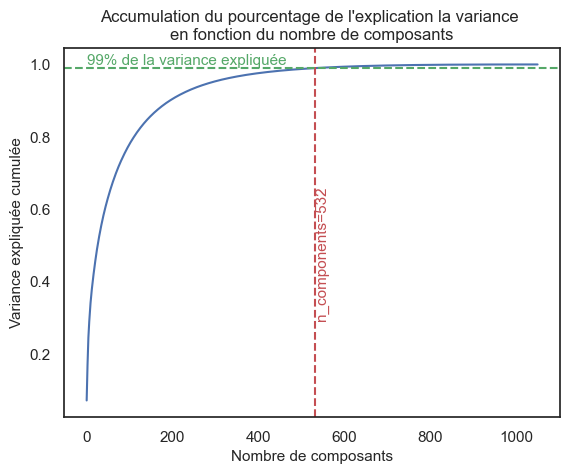

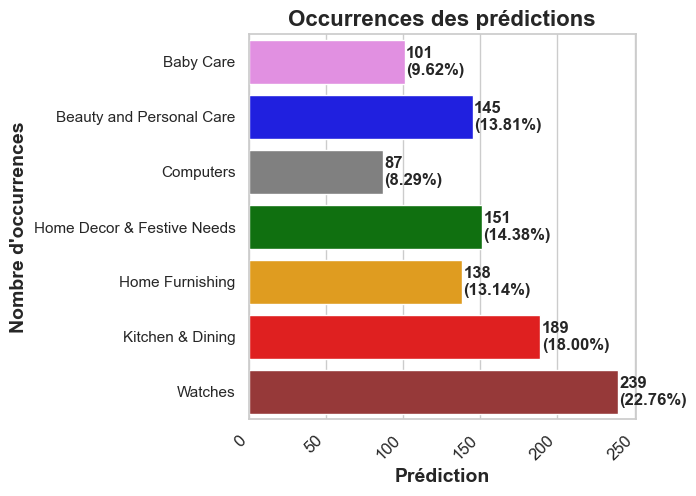

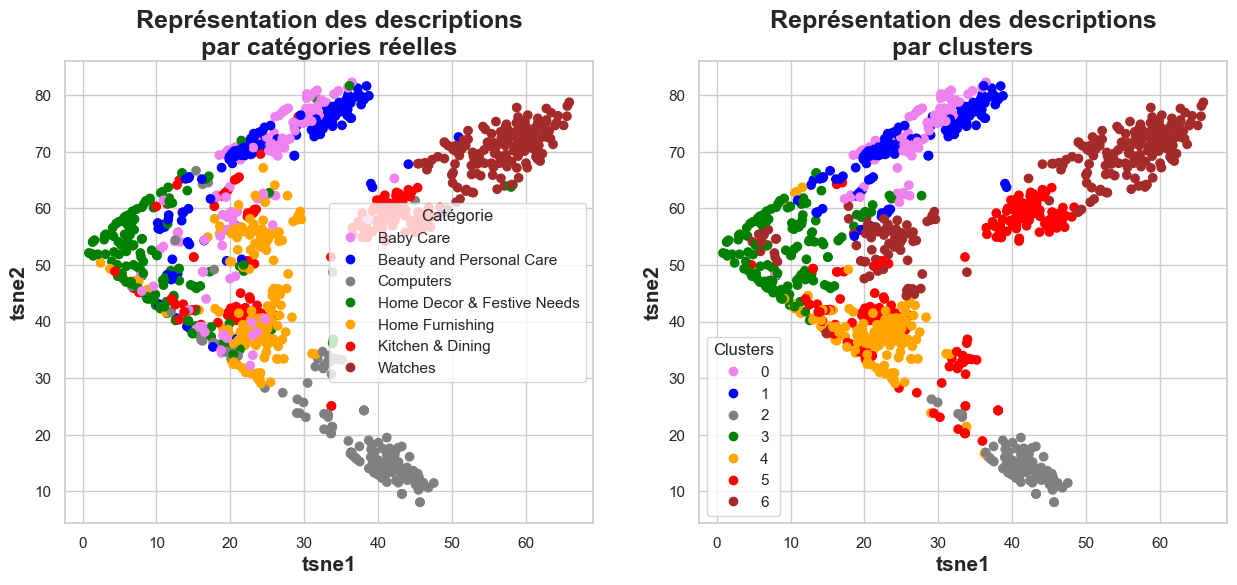

,v_measure,completeness,homogeneity,ARI
0,0.5329,0.5399,0.5261,0.4457


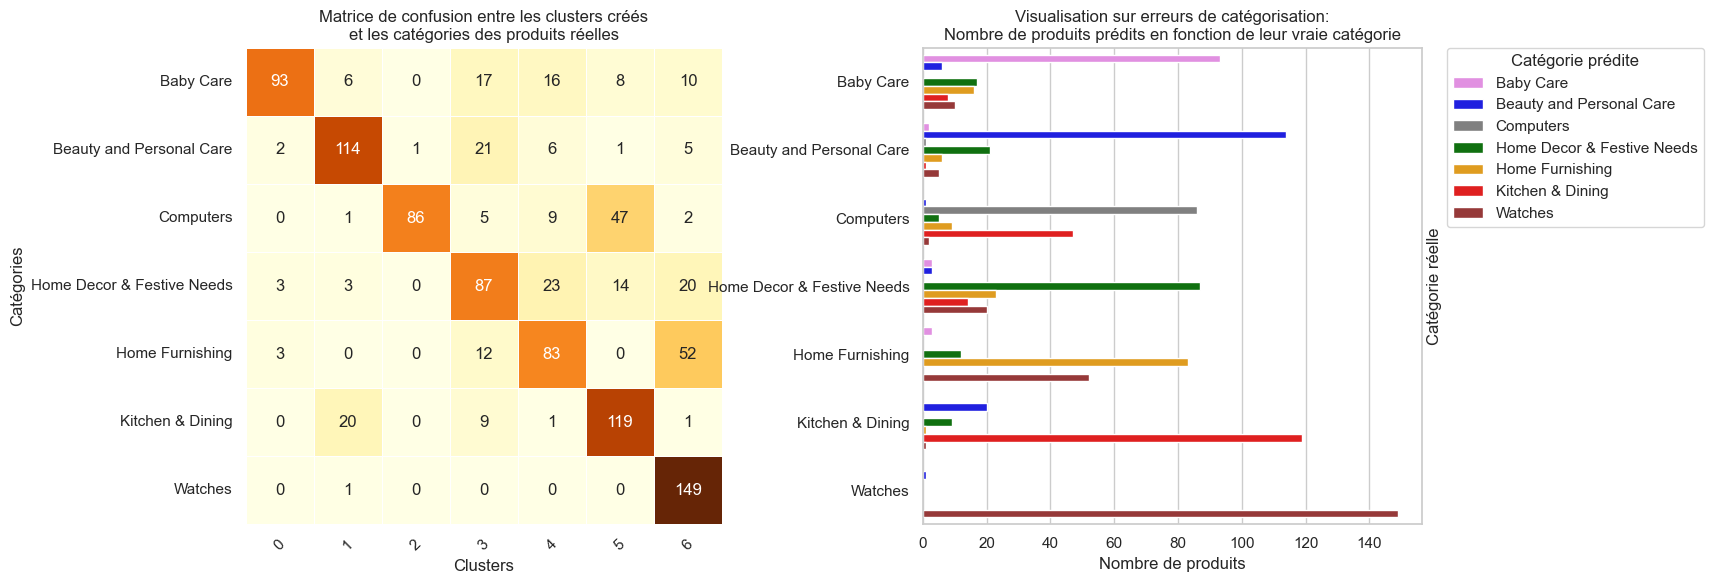

,precision,recall,f1-score,support
0,0.92,0.62,0.74,150.0
1,0.79,0.76,0.77,150.0
2,0.99,0.57,0.73,150.0
3,0.58,0.58,0.58,150.0
4,0.60,0.55,0.58,150.0
5,0.63,0.79,0.70,150.0
6,0.62,0.99,0.77,150.0
accuracy,0.70,0.70,0.70,0.7
macro avg,0.73,0.70,0.69,1050.0
weighted avg,0.73,0.70,0.69,1050.0


CPU times: user 25min 55s, sys: 19min 29s, total: 45min 24s
Wall time: 7min 1s


In [78]:
%%time
# Chargement du modèle pré-entraîné
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input

start_time = time.time()
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetV2L(weights='imagenet', input_tensor=input_tensor)
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
model._name = model_name = 'EfficientNetV2L'
print(model.summary())
print(f'Temps de la récupération du modèle en {round(time.time() - start_time,2)}s')

# Prédiction des features pour chaque image
start_time = time.time()
features = []
i=0 
for image_file in df["IMAGE"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

features = np.asarray(features)
print('Shape of features:', features.shape)
print(f'Temps de la prédiction des featuresen {round(time.time() - start_time,2)}s')

# Réduction ou pas du nombre de features en passant par un Kfold
start_time = time.time()
X_embedded, pred_label, pipeline = perform_dimensionality_reduction(features, use_pca=False, \
    perplexity=25, n_iter=2000, n_clusters=n_clusters, random_state=None)
print(f'Temps de réduction des dimensions des features en {round(time.time() - start_time,2)}s')

# Evaluations graphiques et sous forme de table du modèle non-supervisé
_,_,_ = evaluate_model(model_name, X_embedded, pred_label, true_label, le=le, my_cmap=my_cmap, \
    norm=norm, cat_list=cat_list, palette=palette)

### EfficientNetB7

Model: "EfficientNetV2L"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['input_20[0][0]']            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling_7[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                 

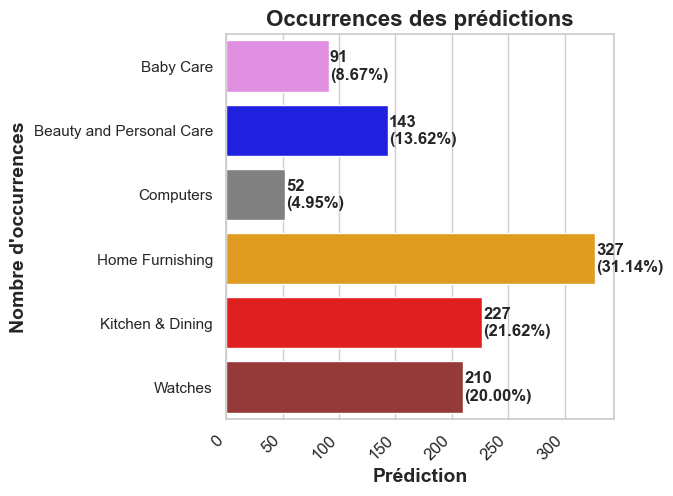

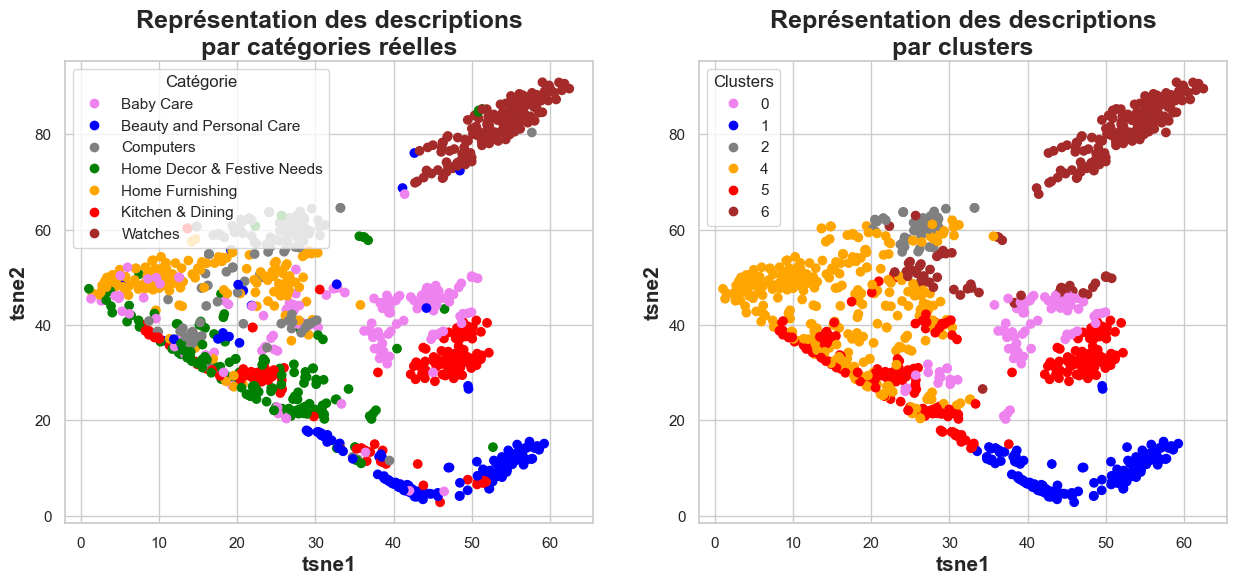

,v_measure,completeness,homogeneity,ARI
0,0.4622,0.5038,0.4269,0.3382


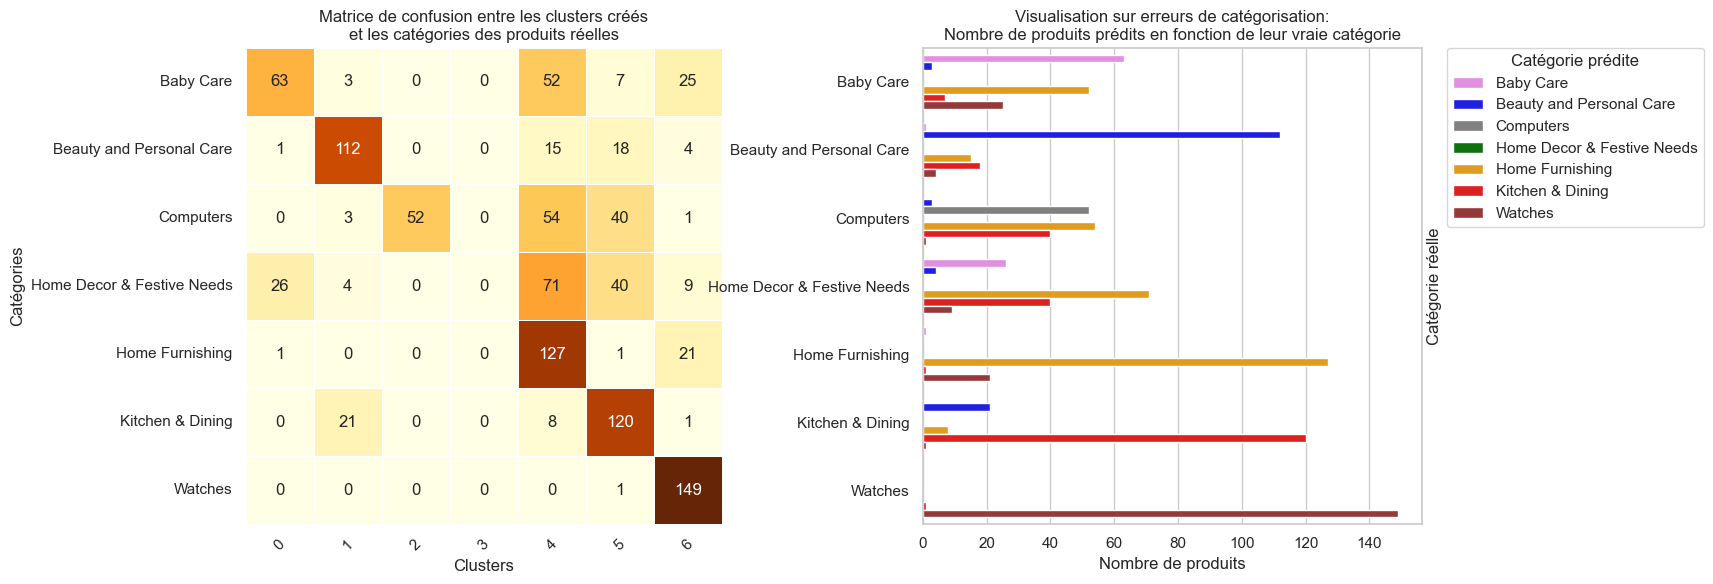

,precision,recall,f1-score,support
0,0.69,0.42,0.52,150.00
1,0.78,0.75,0.76,150.00
2,1.00,0.35,0.51,150.00
3,0.00,0.00,0.00,150.00
4,0.39,0.85,0.53,150.00
5,0.53,0.80,0.64,150.00
6,0.71,0.99,0.83,150.00
accuracy,0.59,0.59,0.59,0.59
macro avg,0.59,0.59,0.54,1050.00
weighted avg,0.59,0.59,0.54,1050.00


CPU times: user 27min 7s, sys: 20min 33s, total: 47min 40s
Wall time: 7min 31s


In [87]:
%%time
# Chargement du modèle pré-entraîné
from tensorflow.keras.applications import EfficientNetB7

start_time = time.time()
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetV2L(weights='imagenet', input_tensor=input_tensor)
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
model._name = model_name = 'EfficientNetV2L'
print(model.summary())
print(f'Temps de la récupération du modèle en {round(time.time() - start_time,2)}s')

# Prédiction des features pour chaque image
start_time = time.time()
features = []
i=0 
for image_file in df["IMAGE"]:
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

features = np.asarray(features)
print('Shape of features:', features.shape)
print(f'Temps de la prédiction des features en {round(time.time() - start_time,2)}s')

# Réduction ou pas du nombre de features en passant par un Kfold
start_time = time.time()
X_embedded, pred_label, pipeline = perform_dimensionality_reduction(features, use_pca=False, \
    perplexity=25, n_iter=2000, n_clusters=n_clusters, random_state=None)
print(f'Temps de réduction des dimensions des features en {round(time.time() - start_time,2)}s')

# Evaluations graphiques et sous forme de table du modèle non-supervisé
_,_,_ = evaluate_model(model_name, X_embedded, pred_label, true_label, le=le, my_cmap=my_cmap, \
    norm=norm, cat_list=cat_list, palette=palette)